In [53]:
#import libraries
import numpy as np
import pandas as pd       
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [2]:
#load data
df_main = pd.read_csv('../data/model_data.csv', low_memory=False)

In [3]:
#establish model variables

X = df_main['combinedtext']
y = df_main['label']

cvec = CountVectorizer(max_features = 1000, stop_words = 'english')

#convert back to dataframe
X_cvec = pd.DataFrame(cvec.fit_transform(X).todense(),
                      columns = cvec.get_feature_names_out())

In [4]:
# Split the data into the training and testing sets. random state set to 88
X_train, X_test, y_train, y_test = train_test_split(X_cvec,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=88)

<b>Define Functions for Modeling</b>

In [5]:
#to obtain probabilities for specific keywords
def cal_mean(source, brand, text):

    if source == 1: #train
        if brand == 0: #flstudio
            try:
                text = combined_train.loc[(combined_train['label'] == 0)].filter(regex=text).values.mean()
                return text
            except:
                return text
        else: 
            try: #ableton
                text = combined_train.loc[(combined_train['label'] == 1)].filter(regex=text).values.mean()
                return text
            except:
                return text
    else: #test
        if brand == 0: #flstudio
            try:
                text = combined_test.loc[(combined_test['label'] == 0)].filter(regex=text).values.mean()
                return text
            except:
                return text
        else: 
            try: #ableton
                text = combined_test.loc[(combined_test['label'] == 1)].filter(regex=text).values.mean()
                return text
            except:
                return text

In [6]:
combined_train = X_train.copy(deep=True)
combined_train['label'] = y_train.copy(deep=True)
combined_test = X_test.copy(deep=True)
combined_test['label'] = y_test.copy(deep=True)

<b>Random Forest Classifier</b><br/><br/>
train cross validation score = 0.909<br/>
test cross valiadation score = 0.909<br/>
accuracy = 91%<br/>
type 1 error (FP) = 406/7982 = 5.1%<br/>
type 2 error (FN) = 293/7982 = 3.7%<br/><br/>
<b>The train and test score shows that the fitting is good. The accuracy is fairly high and the Type 1 and 2 errors are resonably low. This result is faily similar to K-Nearest Neighbour Classifier but RFC is marginally better overall.<b/>

In [7]:
#identify the best model using Grid Search
rfc = RandomForestClassifier()

rfc_params = {'n_estimators': [100, 150, 200], 'max_depth': [None, 1, 2, 3, 4, 5]}
rfc_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=88)

rfc_gs = GridSearchCV(rfc, rfc_params, cv=rfc_cv)
rfc_gs.fit(X_train, y_train)

print(rfc_gs.best_score_)
print(rfc_gs.best_params_)

0.9100229244255565
{'max_depth': None, 'n_estimators': 200}


In [8]:
rfc_gs.score(X_train, y_train)

0.9999382868427549

In [9]:
rfc_gs.score(X_test, y_test)

0.9113004259584064

In [10]:
rfc = RandomForestClassifier(n_estimators = rfc_gs.best_params_['n_estimators'], max_depth = rfc_gs.best_params_['max_depth'])
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [11]:
cross_val_score(rfc, X_train, y_train, cv=rfc_cv).mean()

0.9094674069504421

In [12]:
cross_val_score(rfc, X_test, y_test, cv=rfc_cv).mean()

0.9095478056844237

In [13]:
#indentify keywords that are driving identification
df = pd.DataFrame(rfc.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False)

df.reset_index(inplace=True)
df = df.rename(columns = {'index':'keyword'})
df = df.rename(columns = {0:'importance'})

#brand 1 = ableton and 0 = flstudio 
#source 1 = train and 0 = test
df['ableton_train'] = [cal_mean(1, 1, x) for x in df["keyword"]]
df['flstudio_train'] = [cal_mean(1, 0, x) for x in df["keyword"]]
df['ableton_test'] = [cal_mean(0, 1, x) for x in df["keyword"]]
df['flstudio_test'] = [cal_mean(0, 0, x) for x in df["keyword"]]

In [14]:
#top 10 influencial words by importance
df.head(10)

,keyword,importance,ableton_train,flstudio_train,ableton_test,flstudio_test
0,ableton,0.147749,0.293501,0.008181,0.303360,0.007489
1,fl_studio,0.083378,0.027583,0.534007,0.024842,0.490068
2,fl,0.074967,0.024524,0.272778,0.022857,0.258548
3,live,0.025463,0.145898,0.006801,0.153370,0.007815
4,ableton_live_11,0.018021,0.152558,0.000321,0.162085,0.000000
5,playlist,0.011907,0.004614,0.101700,0.003054,0.101270
6,mixer,0.011347,0.030391,0.155438,0.033394,0.158255
7,ableton_live_10,0.010510,0.101204,0.000481,0.106088,0.000000
8,ableton_live,0.010317,0.094383,0.001203,0.100896,0.001710
9,beat,0.009210,0.069809,0.232435,0.069232,0.209704


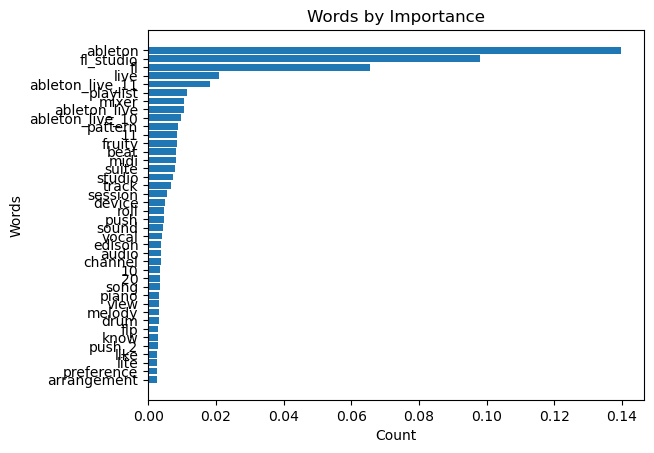

In [56]:
y_axis = list(df.iloc[0:40,0])
x_axis = list(df.iloc[0:40,1])
y_axis.reverse()
x_axis.reverse()

plt.barh(y_axis, x_axis)
plt.title('Words by Importance')
plt.ylabel('Words')
plt.xlabel('Count')
plt.show()

In [47]:
df.to_csv(r'../data/rf_df.csv', index=False)

In [16]:
#calculate pred test values
rfc_y_pred_test = rfc.predict(X_test)

In [17]:
#accuracy score
accuracy_score(y_test, rfc_y_pred_test)

0.9124279629165623

In [18]:
#confusion matrix
confusion_matrix(y_test, rfc_y_pred_test)

array([[2665,  406],
       [ 293, 4618]], dtype=int64)

In [19]:
#classification report
print(classification_report(y_test, rfc_y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      3071
           1       0.92      0.94      0.93      4911

    accuracy                           0.91      7982
   macro avg       0.91      0.90      0.91      7982
weighted avg       0.91      0.91      0.91      7982



<b>K-Nearest Neighbour Classifier</b><br/><br/>
train cross validation score = 0.904<br/>
test cross valiadation score = 0.898<br/>
accuracy = 91%<br/>
type 1 error (FP) = 402/7982 = 5.0%<br/>
type 2 error (FN) = 293/7982 = 4.3%<br/><br/>
<b>The train and test score shows that the fitting is good. The accuracy is fairly high and the Type 1 and 2 errors are resonably low. This result is faily similar to Random Forest Classifier but RFC is marginally better overall.<b/>

In [20]:
#identify the best model using Grid Search

knnc = KNeighborsClassifier()

knnc_params = {'n_neighbors': list(range(1, 31))}
knnc_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=88)

knnc_gs = GridSearchCV(knnc, knnc_params, cv=knnc_cv)
knnc_gs.fit(X_train, y_train)

print(knnc_gs.best_score_)
print(knnc_gs.best_params_)

0.7756732621990693
{'n_neighbors': 30}


In [21]:
knnc_gs.score(X_train, y_train)

0.7944334732164897

In [22]:
knnc_gs.score(X_test, y_test)

0.7617138561763969

In [23]:
knnc = RandomForestClassifier(n_estimators = knnc_gs.best_params_['n_neighbors'])
knnc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=30)

In [24]:
cross_val_score(knnc, X_train, y_train, cv=10).mean()

0.9045292495868272

In [25]:
cross_val_score(knnc, X_test, y_test, cv=10).mean()

0.898396962368374

In [26]:
#indentify keywords that are driving identification
df = pd.DataFrame(knnc.feature_importances_, index=X_train.columns).sort_values(by=0, ascending=False)

df.reset_index(inplace=True)
df = df.rename(columns = {'index':'keyword'})
df = df.rename(columns = {0:'importance'})

#brand 1 = ableton and 0 = flstudio 
#source 1 = train and 0 = test
df['ableton_train'] = [cal_mean(1, 1, x) for x in df["keyword"]]
df['flstudio_train'] = [cal_mean(1, 0, x) for x in df["keyword"]]
df['ableton_test'] = [cal_mean(0, 1, x) for x in df["keyword"]]
df['flstudio_test'] = [cal_mean(0, 0, x) for x in df["keyword"]]

In [27]:
#top 10 influencial words
df.head(10)

,keyword,importance,ableton_train,flstudio_train,ableton_test,flstudio_test
0,ableton,0.139555,0.293501,0.008181,0.303360,0.007489
1,fl_studio,0.098170,0.027583,0.534007,0.024842,0.490068
2,fl,0.065539,0.024524,0.272778,0.022857,0.258548
3,live,0.020931,0.145898,0.006801,0.153370,0.007815
4,ableton_live_11,0.018274,0.152558,0.000321,0.162085,0.000000
5,playlist,0.011424,0.004614,0.101700,0.003054,0.101270
6,mixer,0.010572,0.030391,0.155438,0.033394,0.158255
7,ableton_live,0.010507,0.094383,0.001203,0.100896,0.001710
8,ableton_live_10,0.009630,0.101204,0.000481,0.106088,0.000000
9,pattern,0.008857,0.019057,0.125281,0.019344,0.133181


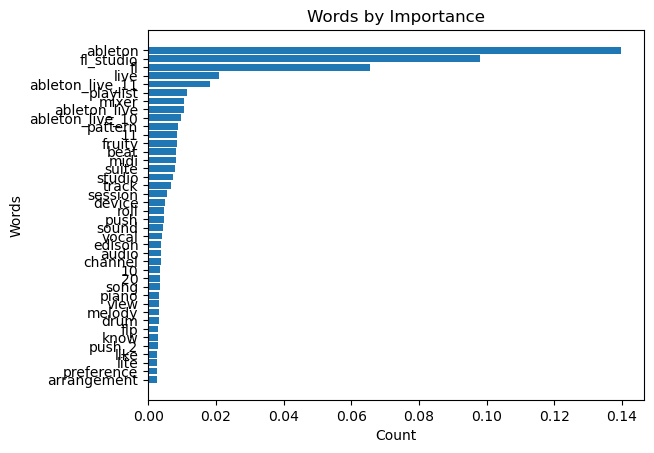

In [55]:
y_axis = list(df.iloc[0:40,0])
x_axis = list(df.iloc[0:40,1])
y_axis.reverse()
x_axis.reverse()

plt.barh(y_axis, x_axis)
plt.title('Words by Importance')
plt.ylabel('Words')
plt.xlabel('Count')
plt.show()

In [49]:
df.to_csv(r'../data/knnc_df.csv', index=False)

In [29]:
#calculate pred test values
knnc_y_pred_test = knnc.predict(X_test)

In [30]:
#accuracy score
accuracy_score(y_test, knnc_y_pred_test)

0.9059133049361062

In [31]:
#confusion matrix
confusion_matrix(y_test, knnc_y_pred_test)

array([[2669,  402],
       [ 349, 4562]], dtype=int64)

In [32]:
#classification report
print(classification_report(y_test, knnc_y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88      3071
           1       0.92      0.93      0.92      4911

    accuracy                           0.91      7982
   macro avg       0.90      0.90      0.90      7982
weighted avg       0.91      0.91      0.91      7982



<b>Support Vector Machines</b><br/><br/>
train cross validation score = 0.894<br/>
test cross valiadation score = 0.882<br/>
accuracy = 0.90%<br/>
type 1 error (FP) = 402/7982 = 5.0%<br/>
type 2 error (FN) = 293/7982 = 5.0%<br/><br/>
<b>The train and test score shows that the fitting is good. The accuracy is fairly high and the Type 1 and 2 errors are resonably low. RFC is still marginally better overall.<b/>

In [58]:
#identify the best model using Grid Search

svc = LinearSVC(max_iter=40000)

# C values to GridSearch over
svc_params = {"C": np.linspace(0.0001, 2, 10)}

svc_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=88)

svc_gs = GridSearchCV(svc, svc_params, cv=svc_cv)
svc_gs.fit(X_test, y_test)

print(svc_gs.best_score_)
print(svc_gs.best_params_)

0.8821126658950253
{'C': 0.2223111111111111}


In [34]:
svc_gs.score(X_train, y_train)

0.8779930881263885

In [35]:
svc_gs.score(X_test, y_test)

0.9564019042846404

In [36]:
svc = LinearSVC(max_iter=20000, C = svc_gs.best_params_['C'])

svc.fit(X_train, y_train)

LinearSVC(C=0.2223111111111111, max_iter=20000)

In [37]:
cross_val_score(svc, X_train, y_train, cv=svc_cv).mean()

0.8941006161415374

In [38]:
cross_val_score(svc, X_test, y_test, cv=svc_cv).mean()

0.8821126658950253

In [50]:
#calculate pred test values
svc_y_pred_test = svc.predict(X_test)

In [51]:
#accuracy score
accuracy_score(y_test, svc_y_pred_test)

0.8966424455023804

In [43]:
#confusion matrix
confusion_matrix(y_test, svc_y_pred_test)

array([[2666,  405],
       [ 420, 4491]], dtype=int64)

In [44]:
#classification report
print(classification_report(y_test, svc_y_pred_test))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      3071
           1       0.92      0.91      0.92      4911

    accuracy                           0.90      7982
   macro avg       0.89      0.89      0.89      7982
weighted avg       0.90      0.90      0.90      7982



In [48]:
df.to_csv(r'../data/svm_df.csv', index=False)

<b>Evaluation Summary</b>

|Model|Train Cross Validation|Test Cross Validation|Accuracy|Type 1 Error|Type 2 Error|
|:---|---:|---:|---:|---:|---:|
|Random Forest Classifier|0.909|0.909|91%|5.1%|3.7%|
|K-Nearest Neighbour Classifier|0.904|0.898|91%|5.0%|4.3%|
|Support Vector Machines|0.894|0.882|90%|5.0%|5.0%|